In [2]:
%reset
import numpy as np
import pandas as pd
import pickle
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import  plot_series
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [2]:
from sktime.registry import all_estimators
import pandas as pd
# all_estimators returns list of pairs - data frame conversion for pretty printing
all_estimators("forecaster", as_dataframe=True)

C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\registry\_lookup.py:158: ImportWarning: No module named 'dtw'. 'dtw' is a soft dependency and not included in the sktime installation. Please run: `pip install dtw`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\registry\_lookup.py:158: ImportWarning: No module named 'tsfresh'. 'tsfresh' is a soft dependency and not included in the sktime installation. Please run: `pip install tsfresh`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\registry\_lookup.py:158: ImportWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: 

,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
6,Croston,<class 'sktime.forecasting.croston.Croston'>
7,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
8,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
9,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


In [15]:
#Ouvre le fichier CSV du capteur dont les données sont issues
df = pd.read_csv("human_activity_raw_sensor_data_float6632.csv", sep=',', header=0, names=["value_id", "sensor_id", "timestamp", "value"])

#Transtypage des colonnes
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['value'] = df['value'].astype('int64')

print(df)

#Selection de la plage de dates à extraire du dataset
df = df[(df['timestamp'] > '2020-05-23') & (df['timestamp'] <= '2020-06-26')]
df = df.set_index('timestamp').asfreq('1min')
df.fillna(method='ffill', inplace=True)

#Suppression des colonnes inutiles pour l'apprentissage
df = df.drop(columns=["sensor_id","value_id"])
df

df['value'].max()

df.drop(df.loc[df['value']<(1/4)*1260.0].index, inplace=True)
df

          value_id  sensor_id           timestamp  value
0        1913482.0       6632 2020-03-23 19:17:00      0
1        1913838.0       6632 2020-03-23 19:18:00      0
2        1914204.0       6632 2020-03-23 19:19:00      0
3        1914546.0       6632 2020-03-23 19:19:59      0
4        1914891.0       6632 2020-03-23 19:21:00      0
...            ...        ...                 ...    ...
185984  64043112.0       6632 2020-08-26 09:56:00      0
185985  64043331.0       6632 2020-08-26 09:56:59      0
185986  64043554.0       6632 2020-08-26 09:58:00      0
185987  64043778.0       6632 2020-08-26 09:59:00      0
185988  64044004.0       6632 2020-08-26 10:00:00      0

[185989 rows x 4 columns]


,value
timestamp,
2020-03-24 12:25:00,1229.0
2020-03-24 13:36:00,1076.0
2020-03-25 11:47:00,1175.0
2020-03-25 11:48:00,418.0
2020-03-25 11:49:00,418.0
...,...
2020-08-15 09:16:00,975.0
2020-08-23 17:26:00,1178.0
2020-08-23 17:27:00,1178.0


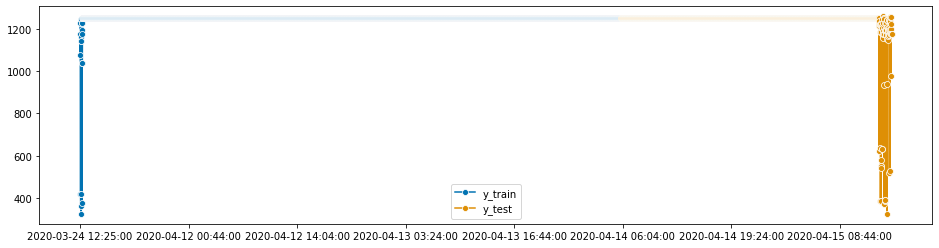

In [16]:
# Slipt test/train des données
y_train, y_test = temporal_train_test_split(df, test_size=1/3)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

                     value
2020-03-23 19:17:00    0.0
2020-03-23 19:18:00    0.0
2020-03-23 19:19:00    0.0
2020-03-23 19:20:00    0.0
2020-03-23 19:21:00    0.0
...                    ...
2020-07-05 06:21:00    0.0
2020-07-05 06:22:00    0.0
2020-07-05 06:23:00    0.0
2020-07-05 06:24:00    0.0
2020-07-05 06:25:00    0.0

[148989 rows x 1 columns]


C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:533: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:543: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\patrick.o

                     value
2020-07-05 06:26:00    0.0
2020-07-05 06:27:00    0.0
2020-07-05 06:28:00    0.0
2020-07-05 06:29:00    0.0
2020-07-05 06:30:00    0.0
2020-07-05 06:31:00    0.0
2020-07-05 06:32:00    0.0
2020-07-05 06:33:00    0.0
2020-07-05 06:34:00    0.0
2020-07-05 06:35:00    0.0
5323672504010281.0


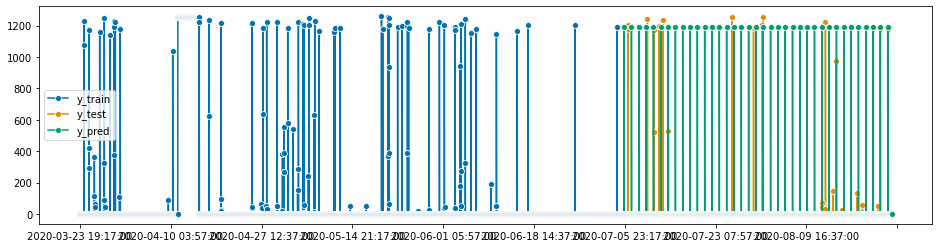

In [14]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=24*12*7)
print(y_train)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
print(y_pred[:10])
#y_pred.fillna(method='ffill', inplace=True)
#y_pred["value"] = y_pred.astype('int64')

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)

# step 4: computing the forecast performance
print(mape(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [5]:
#Sauvegarde du modèle avec Pickle
filename = 'model_5896_bed_pressure.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

                     value
2020-03-23 19:17:00    0.0
2020-03-23 19:18:00    0.0
2020-03-23 19:19:00    0.0
2020-03-23 19:20:00    0.0
2020-03-23 19:21:00    0.0
...                    ...
2020-07-05 06:21:00    0.0
2020-07-05 06:22:00    0.0
2020-07-05 06:23:00    0.0
2020-07-05 06:24:00    0.0
2020-07-05 06:25:00    0.0

[148989 rows x 1 columns]


C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


                             value
2020-07-05 06:26:00  2.256925e-168
2020-07-05 06:27:00  2.256925e-168
2020-07-05 06:28:00  2.256925e-168
2020-07-05 06:29:00  2.256925e-168
2020-07-05 06:30:00  2.256925e-168
2020-07-05 06:31:00  2.256925e-168
2020-07-05 06:32:00  2.256925e-168
2020-07-05 06:33:00  2.256925e-168
2020-07-05 06:34:00  2.256925e-168
2020-07-05 06:35:00  2.256925e-168
0.0004966776293710987


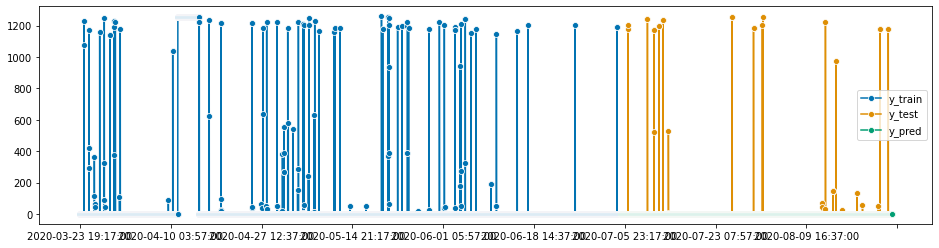

In [14]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(sp=24*7)

fh = ForecastingHorizon(y_test.index, is_relative=False)

print(y_train)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
print(y_pred[:10])
#y_pred.fillna(method='ffill', inplace=True)
#y_pred["value"] = y_pred.astype('int64')

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)

# step 4: computing the forecast performance
print(mape(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.arima import AutoARIMA

ensemble = EnsembleForecaster(forecasters = [("tbats", TBATS()),
                                             ("autoarima", AutoARIMA())],                         
                              aggfunc = "min")
ensemble.fit(y_train)
print(ensemble.forecasters_)

                     value
2020-03-09 00:05:00    0.0
2020-03-09 00:10:00    0.0
2020-03-09 00:15:00    0.0
2020-03-09 00:20:00    0.0
2020-03-09 00:25:00    0.0
...                    ...
2020-03-16 23:40:00    0.0
2020-03-16 23:45:00    0.0
2020-03-16 23:50:00    0.0
2020-03-16 23:55:00    0.0
2020-03-17 00:00:00    0.0

[2304 rows x 1 columns]
                        value
2020-03-17 00:05:00  0.000002
2020-03-17 00:10:00  0.000002
2020-03-17 00:15:00  0.000002
2020-03-17 00:20:00  0.000002
2020-03-17 00:25:00  0.000002
2020-03-17 00:30:00  0.000002
2020-03-17 00:35:00  0.000002
2020-03-17 00:40:00  0.000002
2020-03-17 00:45:00  0.000002
2020-03-17 00:50:00  0.000002
9079256894.405231


C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


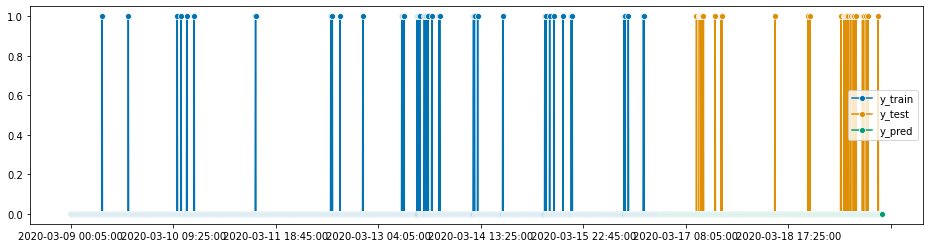

In [15]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(sp=24*12*7)

fh = ForecastingHorizon(y_test.index, is_relative=False)

print(y_train)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
print(y_pred[:10])
#y_pred.fillna(method='ffill', inplace=True)
#y_pred["value"] = y_pred.astype('int64')

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)

# step 4: computing the forecast performance
print(mape(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [16]:
from sktime.forecasting.bats import BATS
forecaster = BATS(sp=24*12*7, use_trend=True, use_box_cox=False)

fh = ForecastingHorizon(y_test.index, is_relative=False)

print(y_train)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
print(y_pred[:10])
#y_pred.fillna(method='ffill', inplace=True)
#y_pred["value"] = y_pred.astype('int64')

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)

# step 4: computing the forecast performance
print(mape(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

                     value
2020-03-09 00:05:00    0.0
2020-03-09 00:10:00    0.0
2020-03-09 00:15:00    0.0
2020-03-09 00:20:00    0.0
2020-03-09 00:25:00    0.0
...                    ...
2020-03-16 23:40:00    0.0
2020-03-16 23:45:00    0.0
2020-03-16 23:50:00    0.0
2020-03-16 23:55:00    0.0
2020-03-17 00:00:00    0.0

[2304 rows x 1 columns]
